# Use this notebook to obtain the files needed to run RiTINI

In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import scanpy as sc
from joblib import Parallel, delayed
import os
import networkx as nx
import re

import matplotlib.pyplot as plt

In [10]:
trajectory_file = '../data/trajectories/traj_data.pkl' 
prior_graph_file='../data/trajectories/cancer_granger_prior_graph_nx_20.pkl'
gene_names_file='../data/trajectories/gene_names.txt'

In [49]:
from pathlib import Path

# Load trajectory data from file
trajectory_path = Path(trajectory_file)
with open(trajectory_path, "rb") as f:
    trajectories = pickle.load(f)

print(trajectories.shape)

gene_names_path = Path(gene_names_file)
with open(gene_names_path, "r") as f:
    gene_names = [line.strip() for line in f.readlines()]

(100, 100, 21465)


In [50]:
seed = 3
np.random.seed(seed)
lag_order = 1 # since we aggregated the data in to 9 bins we only need 1 lag
maxlag = (
    lag_order,  # becuase we got this value before. We are not suppose to add 1 to it
)

n_top_genes = 20

test = "ssr_chi2test"


In [51]:
def grangers_causation_matrix(
    data, in_variables, out_variables, test="ssr_chi2test", n_jobs=1, warn=False
):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """

    def get_pval(dd):
        if warn:
            test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=True)
        else:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=FutureWarning)
                test_result = grangercausalitytests(dd, maxlag=maxlag, verbose=False)
                # according to the documentation https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html,
                # the dd has 2 columns, second causes the first.

        p_values = [test_result[i][0][test][1] for i in maxlag] # test_result[i][1] is the unrestricted model, test_result[i][1][0] is the restricted model
        coefs = [test_result[i][1][1].params[1] for i in maxlag] # x1, x2, const

        arg_min_p_value = np.argmin(p_values)
        min_p_value = p_values[arg_min_p_value]
        min_coef = coefs[arg_min_p_value]
        return (min_p_value, min_coef)

    out = Parallel(n_jobs=n_jobs)(
        delayed(get_pval)(data[[c, r]]) # this means r causes c, so r is be in and c is out
        for c in tqdm(out_variables, desc="Processing columns")  # Outer loop progress bar
        for r in in_variables  # Inner loop without progress bar
    )
    out_p = [p for (p,c) in out]
    out_c = [c for (p,c) in out]
    df_p = pd.DataFrame(
        np.array(out_p).reshape((len(out_variables), len(in_variables))), # should be reshaped to len(out_variables), len(in_variables) according to the for loop.
        columns=in_variables,
        index=out_variables,
    ).T # used the correct reshaping, and then transposed the matrix so the x and y are semantically correct (x causes y).
    df_c = pd.DataFrame(
        np.array(out_c).reshape((len(out_variables), len(in_variables))), # should be reshaped to len(out_variables), len(in_variables) according to the for loop.
        columns=in_variables,
        index=out_variables,
    ).T
    df_p.index = [var + "_x" for var in in_variables]
    df_p.columns = [var + "_y" for var in out_variables]
    df_c.index = [var + "_x" for var in in_variables]
    df_c.columns = [var + "_y" for var in out_variables]
    return df_p, df_c

def do_granger(trajs, in_genes, out_genes, n_jobs=1, warn=False):
    # in causes out
    trajs = trajs.T[::10]
    trajs = trajs - trajs.shift(1)
    trajs = trajs.dropna()
    out_traj_p, out_traj_c = grangers_causation_matrix(
        trajs, in_variables=in_genes, out_variables=out_genes, n_jobs=n_jobs, warn=warn
    )
    return out_traj_p, out_traj_c

In [52]:
import anndata
n_timepoints, n_trajectories, n_genes = trajectories.shape

entire_trajectory = trajectories.reshape(-1, n_genes)

# Create AnnData object for scanpy
adata = anndata.AnnData(X=entire_trajectory)
adata.var_names = gene_names
print(f"Identifying {n_top_genes} highly variable genes.")
# Identify highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=n_top_genes,
)

# Get indices of highly variable genes
selected_genes = np.where(adata.var['highly_variable'])[0]

# Filter trajectories to selected genes
filtered_gene_names = adata.var_names[selected_genes]
filtered_trajectories = trajectories[:, :, selected_genes]

avg_traj = filtered_trajectories.mean(axis=1)

Identifying 20 highly variable genes.


/Users/joaofelipe/Yale/github_projects/ritini_new/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:309: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [58]:
len(db_ensembl_ids)

2765

In [63]:
db_extract = pd.read_csv('../data/trajectories/DatabaseExtract_v_1.01.csv')

db_ensembl_ids = set(db_extract['HGNC symbol'].astype(str))
genes_ensembl_ids = set([g.split('(')[-1].replace(')', '').strip() for g in filtered_gene_names])
in_genes_ensembl = genes_ensembl_ids & db_ensembl_ids
in_genes = [g for g in filtered_gene_names if g.split('(')[-1].replace(')', '').strip() in in_genes_ensembl]

In [64]:
len(in_genes)

1

In [36]:
trajectories_df = pd.DataFrame(avg_traj, columns=filtered_gene_names)

In [37]:
out_traj_p, out_traj_c = do_granger(trajectories_df.T, in_genes, filtered_gene_names, n_jobs=1, warn=False)

Processing columns: 100%|██████████| 20/20 [00:00<00:00, 1098.36it/s]


# Constructing the Prior Graph

Now we take the Granger causality p-values, convert them to -log(p) scores, filter out insignificant values using a threshold, and prepare the resulting matrix (preds) for building the prior graph.

In [38]:
"""
Load Granger causality data to construct the prior graph.
"""
granger_df_all_T = out_traj_p
epsilon = 1e-10
threshold = 5  # You can adjust this value as needed

neg_log_p = -np.log(granger_df_all_T + epsilon)
granger_df_all_T = neg_log_p.where(neg_log_p > threshold, 0)

preds = granger_df_all_T.to_numpy()
tf_count = preds.shape[0]

In [ ]:
# --- Set up labels (gene names) ---
top_genes = list(granger_df_all_T.columns)  # output genes
in_genes = list(granger_df_all_T.index)     # input genes (TFs)

# Extract the part before the space (i.e., the gene symbol)
clean_top_genes = [re.sub(r'\s+\(.*?\)_y$', '', h) for h in top_genes]
top_genes = clean_top_genes
# --- Create directed NetworkX graph ---
G = nx.DiGraph()

# Add nodes (we'll use all output genes as node set)
for idx, gene in enumerate(top_genes):
    G.add_node(idx, label=gene)

# Add edges: r (input gene) -> c (output gene) if significant
for i, input_gene in enumerate(in_genes):
    for j, output_gene in enumerate(top_genes):
        if preds[i, j] >= threshold:
            G.add_edge(i, j)  # node indices match column indices of `top_genes`


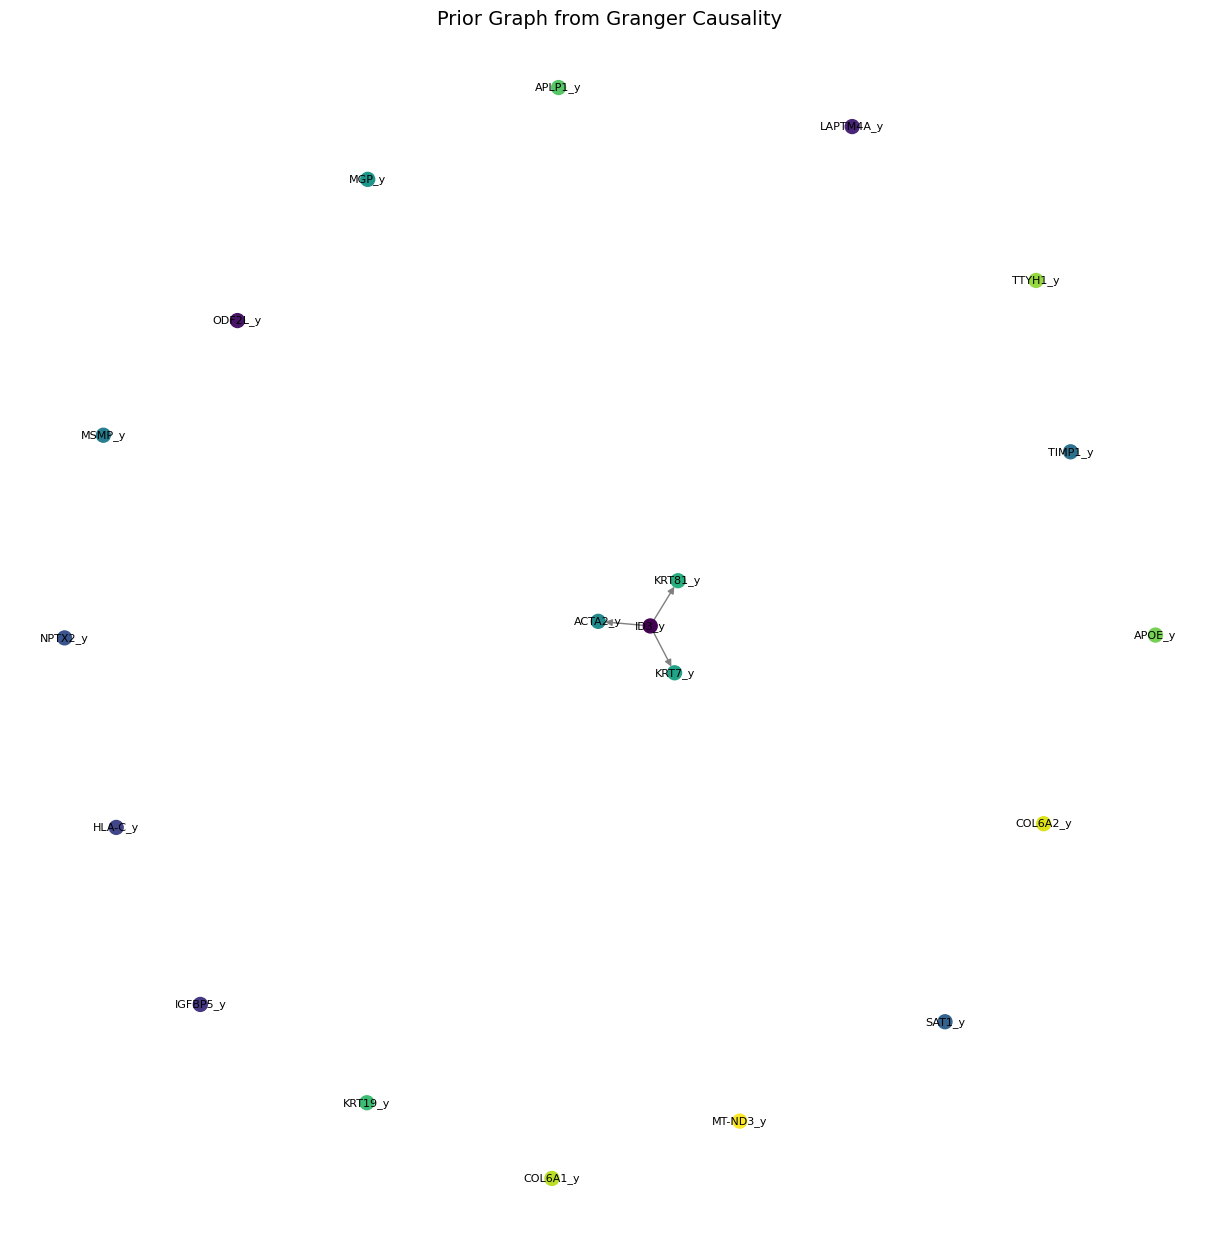

In [43]:
# Set figure size
ref_g = G
ref_pos = nx.spring_layout(ref_g.to_undirected(), seed=seed)


# Color and label
for idx, node in enumerate(ref_g.nodes()):
    ref_g.nodes[node]['color'] = plt.get_cmap('viridis', len(top_genes))(idx)
    ref_g.nodes[node]['label'] = top_genes[idx]


plt.figure(figsize=(12, 12))

# Extract node colors and labels
node_colors = [ref_g.nodes[n]['color'] for n in ref_g.nodes()]
node_labels = {n: ref_g.nodes[n]['label'] for n in ref_g.nodes()}

# Draw the graph
nx.draw(
    ref_g,
    pos=ref_pos,
    with_labels=False,
    node_color=node_colors,
    edge_color='gray',
    arrows=True,
    node_size=100
)

# Draw node labels separately for clarity
nx.draw_networkx_labels(ref_g, pos=ref_pos, labels=node_labels, font_size=8)

plt.title("Prior Graph from Granger Causality", fontsize=14)
plt.axis('off')
plt.show()

# Constructing the Prior Graph

Now we take the Granger causality p-values, convert them to -log(p) scores, filter out insignificant values using a threshold, and prepare the resulting matrix (preds) for building the prior graph.

In [44]:
"""
Load Granger causality data to construct the prior graph.
"""
granger_df_all_T = out_traj_p
epsilon = 1e-10
threshold = 5  # You can adjust this value as needed

neg_log_p = -np.log(granger_df_all_T + epsilon)
granger_df_all_T = neg_log_p.where(neg_log_p > threshold, 0)

preds = granger_df_all_T.to_numpy()
tf_count = preds.shape[0]

In [45]:
# --- Set up labels (gene names) ---
top_genes = list(granger_df_all_T.columns)  # output genes
in_genes = list(granger_df_all_T.index)     # input genes (TFs)

# Extract the part before the space (i.e., the gene symbol)
clean_top_genes = [re.sub(r'\s+\(.*?\)_y$', '', h) for h in top_genes]
top_genes = clean_top_genes
# --- Create directed NetworkX graph ---
G = nx.DiGraph()

# Add nodes (we'll use all output genes as node set)
for idx, gene in enumerate(top_genes):
    G.add_node(idx, label=gene)

# Add edges: r (input gene) -> c (output gene) if significant
for i, input_gene in enumerate(in_genes):
    for j, output_gene in enumerate(top_genes):
        if preds[i, j] >= threshold:
            G.add_edge(i, j)  # node indices match column indices of `top_genes`

# Set figure size
ref_g = G
ref_pos = nx.spring_layout(ref_g.to_undirected(), seed=seed)


# Color and label
for idx, node in enumerate(ref_g.nodes()):
    ref_g.nodes[node]['color'] = plt.get_cmap('viridis', len(top_genes))(idx)
    ref_g.nodes[node]['label'] = top_genes[idx]

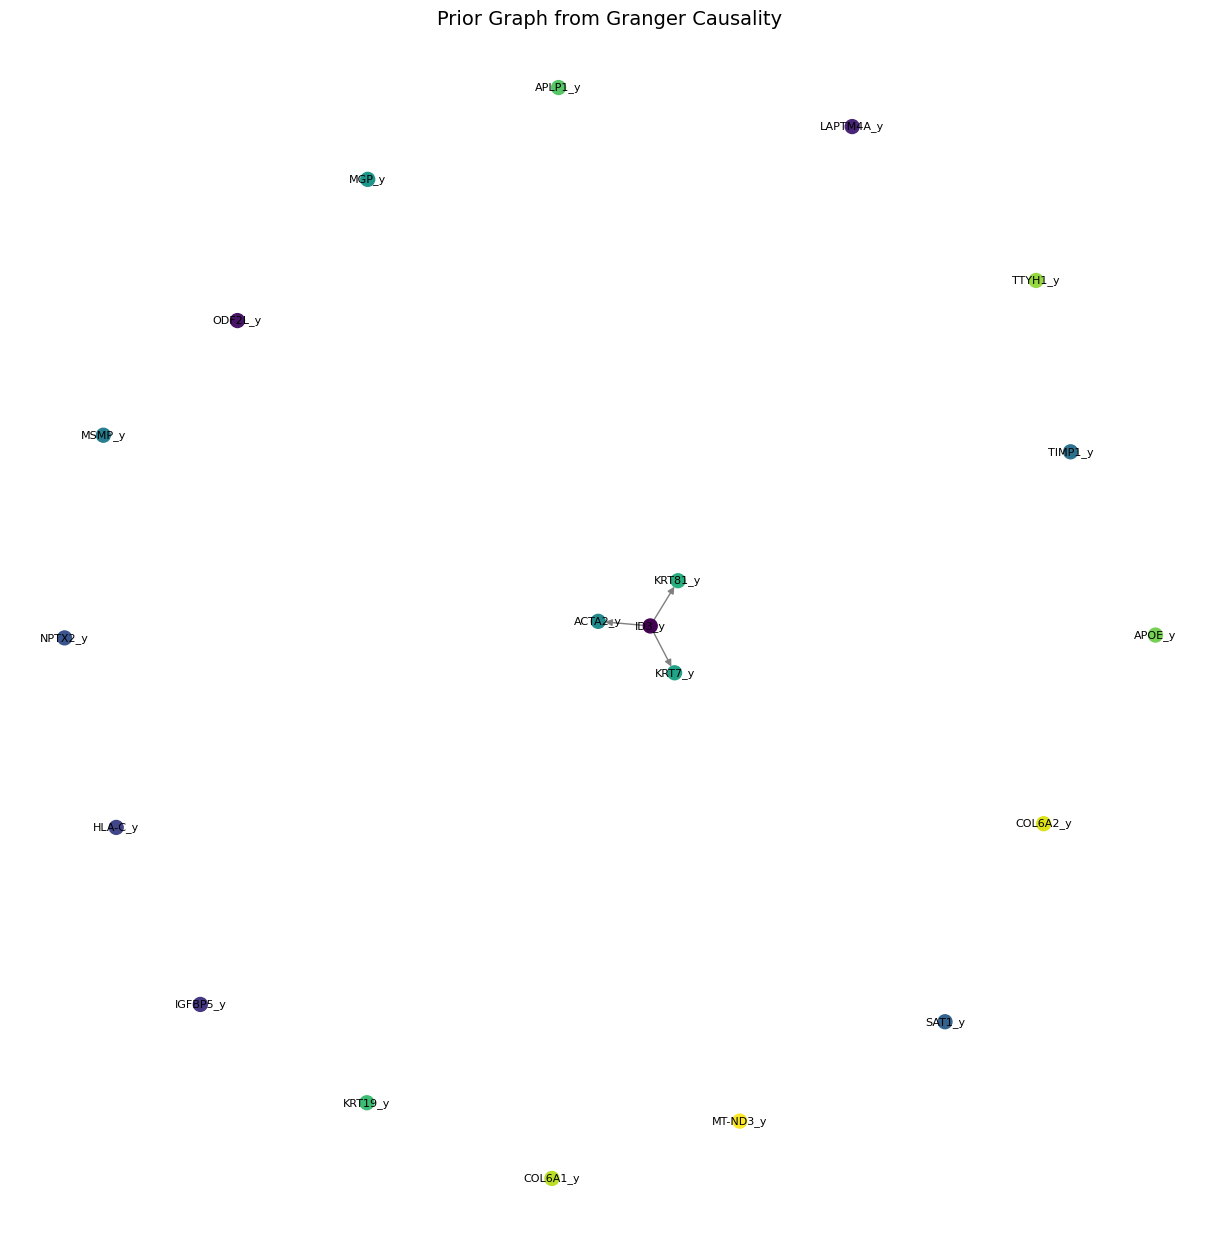

In [46]:
# Set figure size
plt.figure(figsize=(12, 12))

# Extract node colors and labels
node_colors = [ref_g.nodes[n]['color'] for n in ref_g.nodes()]
node_labels = {n: ref_g.nodes[n]['label'] for n in ref_g.nodes()}

# Draw the graph
nx.draw(
    ref_g,
    pos=ref_pos,
    with_labels=False,
    node_color=node_colors,
    edge_color='gray',
    arrows=True,
    node_size=100
)

# Draw node labels separately for clarity
nx.draw_networkx_labels(ref_g, pos=ref_pos, labels=node_labels, font_size=8)

plt.title("Prior Graph from Granger Causality", fontsize=14)
plt.axis('off')
plt.show()